<a href="https://colab.research.google.com/github/pythonuzgit/DSR_project_presentation/blob/main/Dron_Fortfolio_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#

In [ ]:
# we install scikit-learn-extra to get k-medoids
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 14.8 MB/s 


In [ ]:
import skimage.io as io
image_tensor = io.imread('/gdrive/My Drive/dron_image/train_image/DJI_20220913131610_0026_Z.JPG')
image_tensor

array([[[185, 192, 200],
        [184, 191, 199],
        [184, 191, 199],
        ...,
        [166, 192, 209],
        [166, 193, 210],
        [167, 194, 211]],

       [[184, 191, 199],
        [184, 191, 199],
        [184, 191, 199],
        ...,
        [165, 192, 209],
        [165, 192, 209],
        [166, 193, 210]],

       [[185, 192, 200],
        [185, 192, 200],
        [185, 192, 200],
        ...,
        [165, 192, 209],
        [165, 192, 209],
        [165, 193, 207]],

       ...,

       [[ 95, 107,  69],
        [ 92, 102,  65],
        [ 83,  93,  56],
        ...,
        [ 95, 104,  59],
        [100, 109,  64],
        [103, 112,  67]],

       [[ 99, 111,  73],
        [ 98, 108,  71],
        [ 93, 103,  66],
        ...,
        [101, 110,  65],
        [104, 113,  68],
        [106, 115,  70]],

       [[103, 115,  77],
        [105, 115,  78],
        [103, 113,  76],
        ...,
        [105, 114,  69],
        [107, 116,  71],
        [109, 118,  73]]

In [1]:
from PIL import Image
pil_image = Image.fromarray(image_tensor)
pil_image

NameError: name 'image_tensor' is not defined

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048,
    }

    def __init__(self, cuda=False, model='resnet-34', layer='default',
                 layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img:
        :param tensor:
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[:, :]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(1, self.layer_output_size)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[0, :]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [ ]:
# Initialize Img2Vec without GPU
img2vec = Img2Vec(cuda=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

this merges dictionares image_embeddings_dict = {*dogs_and_cats_embeddings, *pets_embeddings}

In [ ]:
embeddings_dictionary = {}
imag_names = []
for index, imag in enumerate(os.listdir(path )):
  #try:
  embeddings_dictionary[imag] = img2vec.get_vec(Image.open(path / imag))
  imag_names.append(imag)
  #except:

In [ ]:
len(embeddings_dictionary),  embeddings_dictionary.keys()

(262,
 dict_keys(['DJI_20220912173905_0001_T.JPG', 'DJI_20220912173906_0001_Z.JPG', 'DJI_20220912173905_0001_W.JPG', 'DJI_20220912173909_0002_T.JPG', 'DJI_20220912173910_0002_Z.JPG', 'DJI_20220912173909_0002_W.JPG', 'DJI_20220913103308_0049_SUPR.JPG', 'DJI_20220913103301_0041_SUPR.JPG', 'DJI_20220913103223_0005_SUPR.JPG', 'DJI_20220913103246_0027_SUPR.JPG', 'DJI_20220913103253_0034_SUPR.JPG', 'DJI_20220913103259_0039_SUPR.JPG', 'DJI_20220913103234_0014_SUPR.JPG', 'DJI_20220913103310_0051_SUPR.JPG', 'DJI_20220913103255_0036_SUPR.JPG', 'DJI_20220913103252_0033_SUPR.JPG', 'DJI_20220913103317_0057_SUPR.JPG', 'DJI_20220913103225_0006_SUPR.JPG', 'DJI_20220913103307_0048_SUPR.JPG', 'DJI_20220913103250_0031_SUPR.JPG', 'DJI_20220913103236_0016_SUPR.JPG', 'DJI_20220913103313_0053_SUPR.JPG', 'DJI_20220913103316_0056_SUPR.JPG', 'DJI_20220913103226_0007_SUPR.JPG', 'DJI_20220913103320_0061_SUPR.JPG', 'DJI_20220913103300_0040_SUPR.JPG', 'DJI_20220913103242_0022_SUPR.JPG', 'DJI_20220913103218_0000_W.J

In [ ]:
import numpy as np

X = []
images = []

for image, embedding in embeddings_dictionary.items():
  X.append(embedding)
  images.append(image)

Finding nearest neighbors

We want to know how similar is every image to its nine closest neighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors
#sklearn give the cosine distance = 1 - cosine_similarity

nbrs = NearestNeighbors(n_neighbors = 9, metric = 'cosine').fit(X)
nbrs

NearestNeighbors(metric='cosine', n_neighbors=9)

In [ ]:
neighbor_similarities, neighbor_indices = nbrs.kneighbors(X)
neighbor_similarities, neighbor_indices

(array([[2.38418579e-07, 6.80418611e-02, 2.53883362e-01, ...,
         3.54800105e-01, 3.62096548e-01, 3.66894066e-01],
        [0.00000000e+00, 2.39258051e-01, 2.50955105e-01, ...,
         3.32397461e-01, 3.42674434e-01, 3.45404029e-01],
        [0.00000000e+00, 8.20125341e-02, 2.50955105e-01, ...,
         2.71011353e-01, 2.76631236e-01, 2.77901053e-01],
        ...,
        [0.00000000e+00, 1.30583048e-02, 2.08009362e-01, ...,
         2.29318738e-01, 2.31686652e-01, 2.31722236e-01],
        [1.19209290e-07, 2.10529327e-01, 2.13063478e-01, ...,
         2.64818192e-01, 2.74943471e-01, 2.78493047e-01],
        [0.00000000e+00, 3.26395035e-04, 9.99990702e-02, ...,
         1.18317366e-01, 1.23571873e-01, 1.25105381e-01]], dtype=float32),
 array([[  0,   3, 226, ..., 204, 256,   1],
        [  1,   5,   2, ...,   4, 210, 223],
        [  2,   5,   1, ...,   0, 159, 198],
        ...,
        [259, 235, 204, ..., 240, 232, 226],
        [260, 191, 250, ..., 151, 203, 157],
        [261

In [ ]:
from numpy.linalg import norm
def cosine_similarity(vector_a, vector_b):
    return np.inner(vector_a, vector_b) / (norm(vector_a) * norm(vector_b))


neighborhoods_dict = {}
for i in range(len(neighbor_indices)):
    center_image = images[neighbor_indices[i, 0]]
    neighbors_list = [];
    for j in range(0, len(neighbor_indices[0])):
        neighbor_image = images[neighbor_indices[i][j]]
        neighbor_similarity = 1.0 - neighbor_similarities[i][j]
        neighbors_list.append([neighbor_image, neighbor_similarity])
    neighborhoods_dict[center_image] = neighbors_list

In [ ]:
neighborhoods_dict

{'DJI_20220912173905_0001_T.JPG': [['DJI_20220912173905_0001_T.JPG',
   0.9999997615814209],
  ['DJI_20220912173909_0002_T.JPG', 0.9319581389427185],
  ['frame22.jpg', 0.7461166381835938],
  ['DJI_20220912173905_0001_W.JPG', 0.7289886474609375],
  ['frame37.jpg', 0.6834245920181274],
  ['DJI_20220912173909_0002_W.JPG', 0.6764531135559082],
  ['frame0.jpg', 0.6451998949050903],
  ['frame52.jpg', 0.6379034519195557],
  ['DJI_20220912173906_0001_Z.JPG', 0.6331059336662292]],
 'DJI_20220912173906_0001_Z.JPG': [['DJI_20220912173906_0001_Z.JPG', 1.0],
  ['DJI_20220912173909_0002_W.JPG', 0.7607419490814209],
  ['DJI_20220912173905_0001_W.JPG', 0.7490448951721191],
  ['DJI_20220913103225_0006_SUPR.JPG', 0.7131137847900391],
  ['DJI_20220913103235_0015_SUPR.JPG', 0.6974099278450012],
  ['DJI_20220913103241_0021_SUPR.JPG', 0.6783173084259033],
  ['DJI_20220912173910_0002_Z.JPG', 0.6676025390625],
  ['frame6.jpg', 0.6573255658149719],
  ['frame19.jpg', 0.6545959711074829]],
 'DJI_20220912173905_0

In [ ]:
image_list = list(neighborhoods_dict.keys())
len(image_list)

258

In [ ]:
full_paths[neighborhoods_dict['DJI_20220913130325_0002_Z.JPG'][1][0]]

PosixPath('/gdrive/My Drive/dron_image/train_image/DJI_20220913130328_0003_Z.JPG')

In [ ]:
neighborhoods_dict['DJI_20220913130325_0002_Z.JPG']

[['DJI_20220913130325_0002_Z.JPG', 1.0],
 ['DJI_20220913130328_0003_Z.JPG', 0.9893158078193665],
 ['frame40.jpg', 0.9544461369514465],
 ['DJI_20220913131155_0020_Z.JPG', 0.9371674060821533],
 ['DJI_20220913131148_0018_Z.JPG', 0.9369525909423828],
 ['DJI_0014.JPG', 0.9358502626419067],
 ['DJI_20220913131205_0022_Z.JPG', 0.9356292486190796],
 ['DJI_20220913131159_0021_Z.JPG', 0.931844174861908],
 ['DJI_0013.JPG', 0.9287700653076172]]

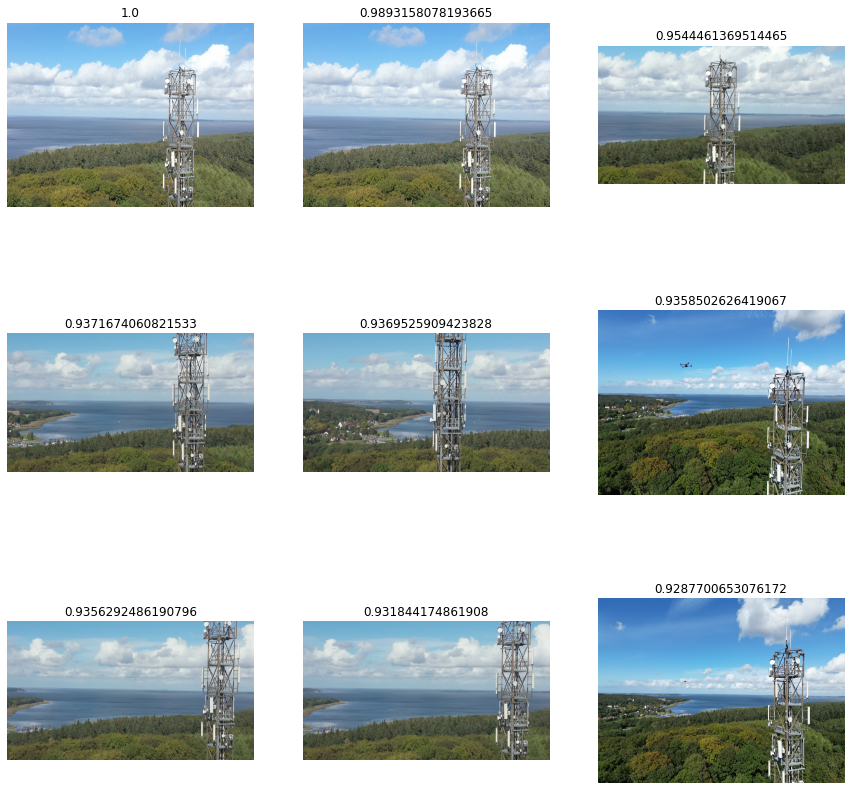

In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt

# quick and dirty plot, which is the biggest flaw here? :D
# how can we write a quick fix to the path?
def plot_neighborhood(neighbors_row):
  f, axarr = plt.subplots(3,3, figsize=(15,15))


  axarr[0][0].imshow(io.imread(full_paths[neighbors_row[0][0]]))
  axarr[0][1].imshow(io.imread(full_paths[neighbors_row[1][0]]))
  axarr[0][2].imshow(io.imread(full_paths[neighbors_row[2][0]]))
  axarr[1][0].imshow(io.imread(full_paths[neighbors_row[3][0]]))
  axarr[1][1].imshow(io.imread(full_paths[neighbors_row[4][0]]))
  axarr[1][2].imshow(io.imread(full_paths[neighbors_row[5][0]]))
  axarr[2][0].imshow(io.imread(full_paths[neighbors_row[6][0]]))
  axarr[2][1].imshow(io.imread(full_paths[neighbors_row[7][0]]))
  axarr[2][2].imshow(io.imread(full_paths[neighbors_row[8][0]]))

  axarr[0, 0].set_title(neighbors_row[0][1])
  axarr[0, 1].set_title(neighbors_row[1][1])
  axarr[0, 2].set_title(neighbors_row[2][1])
  axarr[1, 0].set_title(neighbors_row[3][1])
  axarr[1, 1].set_title(neighbors_row[4][1])
  axarr[1, 2].set_title(neighbors_row[5][1])
  axarr[2, 0].set_title(neighbors_row[6][1])
  axarr[2, 1].set_title(neighbors_row[7][1])
  axarr[2, 2].set_title(neighbors_row[8][1])

  for i in range(3):
        for j in range(3):
            axarr[i, j].axis('off')

#plot_neighborhood(neighborhoods_dict['neighborhoods_dict['DJI_20220913130325_0002_Z.JPG']'])
#plot_neighborhood(neighborhoods_dict['DJI_20220913130325_0002_Z.JPG'])

plot_neighborhood(neighborhoods_dict['DJI_20220913130325_0002_Z.JPG'])



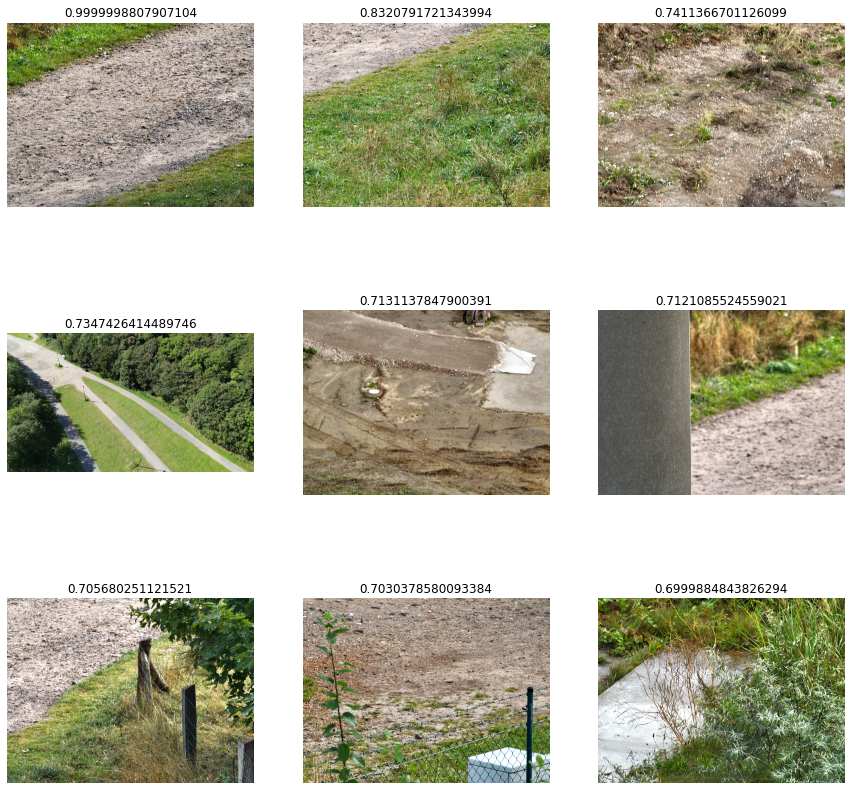

In [ ]:
#@title Image browser {run:"auto"}


slider_value = 61  #@param {type: "slider", min: 0, max: 150}
plot_neighborhood(neighborhoods_dict[image_list[slider_value]])

In [ ]:
image_embeddings_dict = embeddings_dictionary

# separate images and embeddings
embeddings = []
images = []
for image, embedding in image_embeddings_dict.items():
    embeddings.append(embedding)
    images.append(image)

In [ ]:
import numpy as np
X = np.array(embeddings)
X.shape

(262, 512)

In [ ]:
import numpy as np
images = np.array(images)
images.shape

(262,)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from tqdm.notebook import tqdm
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
import matplotlib as mpl
#from matplotlib import _api, _docstring
import matplotlib.artist as martist
import matplotlib.path as mpath
import matplotlib.text as mtext
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from matplotlib.image import BboxImage
from matplotlib.patches import (
    FancyBboxPatch, FancyArrowPatch, bbox_artist as mbbox_artist)
from matplotlib.transforms import Bbox, BboxBase, TransformedBbox

In [ ]:
def scatter_thumbnails(data, images, zoom = 0.12, color = None):
  assert len(data) == len(images)

  #reduce embedding dimensions to 2
  x = PCA(n_components = 2).fit_transform(data) if len(data[0]) > 2 else data

  #create a scatter plot
  f = plt.figure(figsize = (22, 15))
  ax = plt.subplot(aspect = 'equal')
  sc = ax.scatter(x[:, 0], x[:, 1], s = 4 )
  _ = ax.axis('off')
  _ = ax.axis('tight')

  #add thumbnails :)

  #from maplotlib.offsetbox import OffsetImage, AnnotationBbox
  from matplotlib.offsetbox import OffsetImage, AnnotationBbox

  #full_paths[representative_images[i]

  #io.imread(full_paths[representative_images[i]])

  for i in range(len(embeddings_dictionary)):
    image = plt.imread(full_paths[images[i]])
    im = OffsetImage(image, zoom=zoom)
    bboxprops = dict(edgecolor=color[i]) if color is not None else None
    #bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
    ab = AnnotationBbox(im, x[i], xycoords='data',
                            frameon=(bboxprops is not None),
                            pad=0.02,
                            bboxprops=bboxprops)

    ax.add_artist(ab)

  return ax

_ = scatter_thumbnails(embeddings, images)
plt.title('Facial Embeddings - Principal Component Analysis')
plt.show()



TypeError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f806700e160> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f8066daed30> (for post_execute):


KeyboardInterrupt: ignored

Selecting 37 representative images (medoids)

In [ ]:
from sklearn_extra.cluster import KMedoids
# We want to create the model with 37 clusters,
# dividing vectors using the cosine similarity metric
# and using the k-medoids++ initialization algorithm
# we want to define a random_state to make our result reproducible
kmedoids = KMedoids(n_clusters=100, random_state=0,
                        init='k-medoids++', metric='cosine').fit(X)

In [ ]:
#assignment of images to different clusters
image_clusters = dict(zip(images, kmedoids.labels_))
image_clusters

{'DJI_20220912173905_0001_T.JPG': 12,
 'DJI_20220912173906_0001_Z.JPG': 52,
 'DJI_20220912173905_0001_W.JPG': 26,
 'DJI_20220912173909_0002_T.JPG': 12,
 'DJI_20220912173910_0002_Z.JPG': 22,
 'DJI_20220912173909_0002_W.JPG': 26,
 'DJI_20220913103308_0049_SUPR.JPG': 42,
 'DJI_20220913103301_0041_SUPR.JPG': 58,
 'DJI_20220913103223_0005_SUPR.JPG': 27,
 'DJI_20220913103246_0027_SUPR.JPG': 49,
 'DJI_20220913103253_0034_SUPR.JPG': 56,
 'DJI_20220913103259_0039_SUPR.JPG': 69,
 'DJI_20220913103234_0014_SUPR.JPG': 79,
 'DJI_20220913103310_0051_SUPR.JPG': 70,
 'DJI_20220913103255_0036_SUPR.JPG': 82,
 'DJI_20220913103252_0033_SUPR.JPG': 10,
 'DJI_20220913103317_0057_SUPR.JPG': 65,
 'DJI_20220913103225_0006_SUPR.JPG': 22,
 'DJI_20220913103307_0048_SUPR.JPG': 19,
 'DJI_20220913103250_0031_SUPR.JPG': 43,
 'DJI_20220913103236_0016_SUPR.JPG': 68,
 'DJI_20220913103313_0053_SUPR.JPG': 42,
 'DJI_20220913103316_0056_SUPR.JPG': 66,
 'DJI_20220913103226_0007_SUPR.JPG': 60,
 'DJI_20220913103320_0061_SUPR.JPG

In [ ]:
clusters, counts = np.unique(kmedoids.labels_, return_counts=True)

cluster_counts = sorted(list(zip(clusters, counts)), key=lambda x:x[-1], reverse=True)
cluster_counts = dict(cluster_counts)
cluster_counts

{0: 15,
 21: 9,
 30: 9,
 35: 9,
 54: 9,
 4: 7,
 15: 7,
 1: 6,
 70: 6,
 6: 5,
 48: 5,
 56: 5,
 58: 5,
 63: 5,
 3: 4,
 10: 4,
 19: 4,
 23: 4,
 25: 4,
 39: 4,
 55: 4,
 72: 4,
 73: 4,
 16: 3,
 18: 3,
 20: 3,
 22: 3,
 33: 3,
 34: 3,
 47: 3,
 49: 3,
 84: 3,
 85: 3,
 89: 3,
 91: 3,
 92: 3,
 2: 2,
 5: 2,
 7: 2,
 8: 2,
 12: 2,
 13: 2,
 14: 2,
 17: 2,
 26: 2,
 28: 2,
 31: 2,
 36: 2,
 40: 2,
 41: 2,
 42: 2,
 46: 2,
 67: 2,
 77: 2,
 79: 2,
 81: 2,
 83: 2,
 9: 1,
 11: 1,
 24: 1,
 27: 1,
 29: 1,
 32: 1,
 37: 1,
 38: 1,
 43: 1,
 44: 1,
 45: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 57: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 64: 1,
 65: 1,
 66: 1,
 68: 1,
 69: 1,
 71: 1,
 74: 1,
 75: 1,
 76: 1,
 78: 1,
 80: 1,
 82: 1,
 86: 1,
 87: 1,
 88: 1,
 90: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1}

In [ ]:
representative_images = []
representative_embeddings = []
cluster_number_repr_images = []
for image, embedding in embeddings_dictionary.items():

    for cluster_number, repr_embedding in enumerate(kmedoids.cluster_centers_):
        comparison = np.equal(repr_embedding, embedding)
        if comparison.all():
            representative_images.append(image)
            representative_embeddings.append(embedding)
            cluster_number_repr_images.append(cluster_number)

In [ ]:
len(representative_images)

102

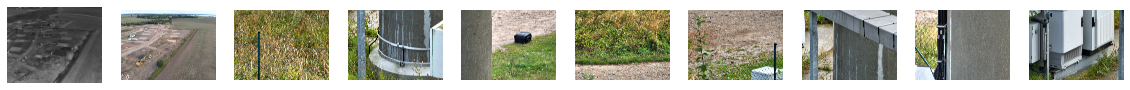

In [ ]:
f, axarr = plt.subplots(1, 10, figsize=(20, 20))

for i in range(10):
  axarr[i].imshow(io.imread(full_paths[representative_images[i]]))
  axarr[i].axis('off')

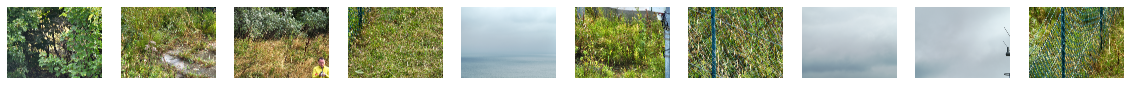

In [ ]:
f, axarr = plt.subplots(1, 10, figsize=(20, 20))

for i in range(10):
  axarr[i].imshow(io.imread(full_paths[representative_images[10+i]]))
  axarr[i].axis('off')

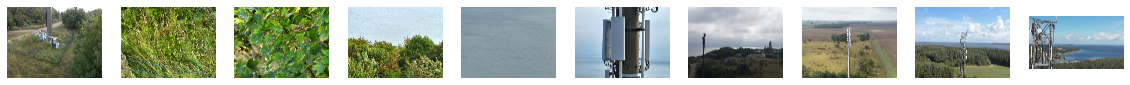

In [ ]:
f, axarr = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
  axarr[i].imshow(io.imread(full_paths[representative_images[20+i]]))
  axarr[i].axis('off')

Choosing an 'optimal' number of clusters based on the elbow method
We want to see find where the inflexion point happens.

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters.

Inertia: It is the sum of squared distances of samples to their closest cluster center.

In [ ]:
# we choose a smaller dataset for this experiment
# (we can go out of RAM in Colab quite easily)
image_embeddings_dict = embeddings_dictionary

# separate images and embeddings
embeddings = []
images = []
for image, embedding in image_embeddings_dict.items():
    embeddings.append(embedding)
    images.append(image)

In [ ]:
import numpy as np
X = np.array(embeddings)
X.shape

(262, 512)

In [ ]:
image_embeddings_dict = embeddings_dictionary

In [ ]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 90, 2)

for k in K:
    #Building and fitting the model
    kmedoidModel = KMedoids(n_clusters=k, random_state=0, init='k-medoids++').fit(X)

    distortions.append(sum(np.min(cdist(X, kmedoidModel.cluster_centers_,
                      'cosine'),axis=1)) / X.shape[0])
    inertias.append(kmedoidModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmedoidModel.cluster_centers_,
                 'cosine'),axis=1)) / X.shape[0]
    mapping2[k] = kmedoidModel.inertia_

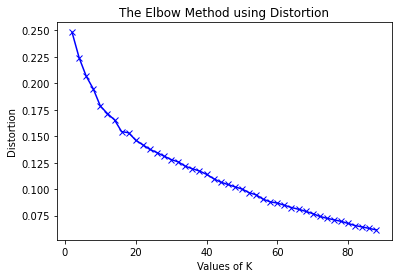

In [ ]:
plt.plot(K, distortions, 'bx-')
#fig = plt.figure(figsize=(12, 6))
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()
#plt.savefig('distortions.png', dpi=fig.dpi)

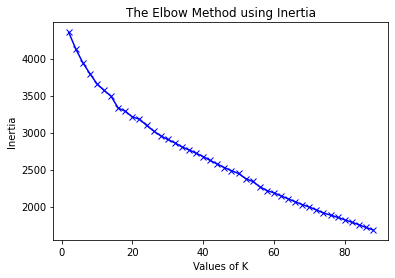

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Principal Component Analysis (PCA)

In [ ]:
import numpy as np
images = np.array(images)
images.shape

(262,)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from tqdm.notebook import tqdm
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
import matplotlib as mpl
#from matplotlib import _api, _docstring
import matplotlib.artist as martist
import matplotlib.path as mpath
import matplotlib.text as mtext
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from matplotlib.image import BboxImage
from matplotlib.patches import (
    FancyBboxPatch, FancyArrowPatch, bbox_artist as mbbox_artist)
from matplotlib.transforms import Bbox, BboxBase, TransformedBbox

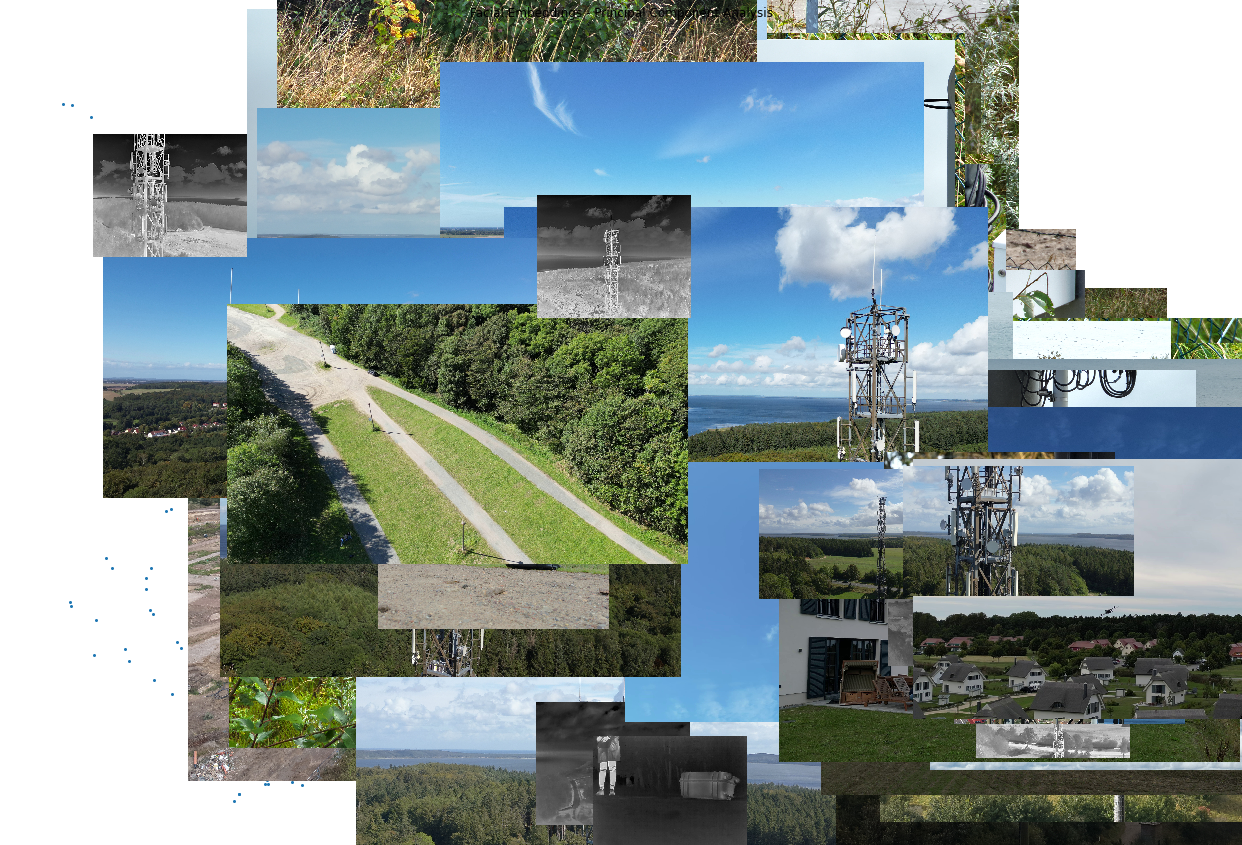

In [ ]:
def scatter_thumbnails(data, images, zoom = 0.12, color = None):
  assert len(data) == len(images)

  #reduce embedding dimensions to 2
  x = PCA(n_components = 2).fit_transform(data) if len(data[0]) > 2 else data

  #create a scatter plot
  f = plt.figure(figsize = (22, 15))
  ax = plt.subplot(aspect = 'equal')
  sc = ax.scatter(x[:, 0], x[:, 1], s = 4 )
  _ = ax.axis('off')
  _ = ax.axis('tight')

  #add thumbnails :)

  #from maplotlib.offsetbox import OffsetImage, AnnotationBbox
  from matplotlib.offsetbox import OffsetImage, AnnotationBbox

  #full_paths[representative_images[i]

  #io.imread(full_paths[representative_images[i]])

  for i in range(len(representative_images)):
    image = plt.imread(full_paths[representative_images[i]])
    im = OffsetImage(image, zoom=zoom)
    bboxprops = dict(edgecolor=color[i]) if color is not None else None
    #bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
    ab = AnnotationBbox(im, x[i], xycoords='data',
                            frameon=(bboxprops is not None),
                            pad=0.02,
                            bboxprops=bboxprops)

    ax.add_artist(ab)

  return ax

_ = scatter_thumbnails(embeddings, images)
plt.title('Facial Embeddings - Principal Component Analysis')
plt.show()

